# Imports

In [98]:
import sys
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Constants

In [69]:
example_file = "SpamData/01_Processing/practice_email.txt"

spam_1_path = "SpamData/01_Processing/spam_assassin_corpus/spam_1/"
spam_2_path = "SpamData/01_Processing/spam_assassin_corpus/spam_2/"
easy_nonspam_1_path = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/"
easy_nonspam_2_path = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/"

spam_cat = 1
ham_cat = 0

data_json_file = "SpamData/01_Processing/email-text-data.json"

# Reading Files

In [8]:
stream = open(example_file, encoding='latin-1') #open the file
message = stream.read() # read and store the contents
stream.close() #close our stream

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

**Encoding** is how the computer handles letters and text. After all, every character needs to be translated into ones and zeros.

In [7]:
sys.getfilesystemencoding() #defualt encoding type.

'utf-8'

We need to just print out message body instead of the header and the message body.

In [10]:
# We will use empty space after message body as a decision point

stream = open(example_file, encoding='latin-1') 

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n': #this chcek for empty spaces
       is_body = True 


stream.close()

email_body = '\n'.join(lines) # Joining every element in list.
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions and Gathering Data

Function for reading all the files in the folder

In [12]:
def email_body_generator(path):
    """This function loops over particular file in our directory. Split out filenames and then email body. """
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:

            filepath = join(root, file_name)

            stream = open(filepath, encoding='latin-1') 

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n': #this chcek for empty spaces
                    is_body = True 

            stream.close()
            email_body = '\n'.join(lines) # Joining every element in list.

            yield file_name, email_body    

In [16]:
def df_from_directory(path, classification):

    rows = []
    row_names = []

    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [28]:
spam_emails = df_from_directory(spam_1_path, spam_cat) #Category for spam 1
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [37]:
spam_emails_2 = df_from_directory(spam_2_path, spam_cat)
spam_emails = pd.concat([spam_emails, spam_emails_2])

In [38]:
spam_emails.shape

(1898, 2)

In [41]:
ham_emails = df_from_directory(easy_nonspam_1_path, ham_cat)
ham_emails_2 = df_from_directory(easy_nonspam_2_path, ham_cat)

ham_emails = pd.concat([ham_emails, ham_emails_2])

ham_emails.head()

,MESSAGE,CATEGORY
00769.25bf9a767b5db0ed93f03c1637281663,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ...",0
01074.8590d61ac0aeeadb58dc2f2ba776c406,"Hiya, I always seem to get errors when I do an...",0
02479.14365bcad3a60fcf24c5c1813f6291fb,\n\nI don't know how one can expect better and...,0
01417.ce7b07a2114218dbac682b599785820d,Tim Peters wrote:\n\n> I've run no experiments...,0
00357.d559b71616f64ba1d1c1e61a03644fd4,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...",0


In [42]:
ham_emails.shape

(3901, 2)

In [45]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire df:', data.shape)
data.tail()

Shape of entire df: (5799, 2)


,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


# Cleaning Data

In [49]:
data.MESSAGE.isnull().values.any() # Checking for if any message is null

False

In [54]:
#Check if there are empty emails

(data.MESSAGE.str.len() == 0).any()

True

In [55]:
(data.MESSAGE.str.len() == 0).sum() # 3 emails are empty

3

In [57]:
data[data.MESSAGE.str.len() == 0].index #empty files with index names

#cmds comes from unzipping, its a system file we dont need this

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [59]:
data.drop(['cmds'],inplace=True) #dropping system files

In [61]:
data.shape

(5796, 2)

Add document IDs to Track Emails in DF

In [63]:
document_ids = range(0,len(data.index))

data['DOC_ID'] = document_ids

data.head()

,MESSAGE,CATEGORY,DOC_ID
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,0
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1,2
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,3
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1,4


In [65]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


### Save Data

In [70]:
data.to_json(data_json_file)

In [71]:
data.CATEGORY.value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

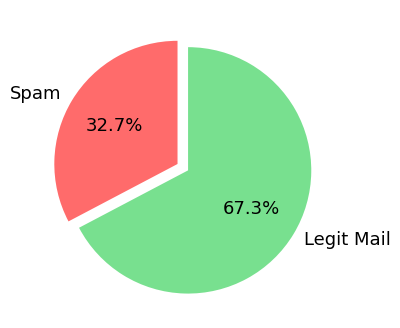

In [97]:
amounts_of_spam = data.CATEGORY.value_counts()[1]
amounts_of_ham = data.CATEGORY.value_counts()[0]

category_names = ['Spam', 'Legit Mail']
sizes = [amounts_of_spam, amounts_of_ham]
custom_colors = ['#ff6b6b', '#78e08f']

plt.figure(figsize=(4,4))
plt.pie(sizes, labels=category_names, textprops={'fontsize': 13}, startangle= 90,
         autopct='%1.1f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

## Pre-Processing 

- Converting to lower case
- Tokenising
- Removing stop words (the, I, of , at, which, on, etc.)
- Stripping out HTML Tags
- Word stemming
- Remove punctuation


Download the NLTK Resources

In [99]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/burakbedir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/burakbedir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True